In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [149]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (6.5, 4)
plt.rcParams["figure.dpi"] = 150

In [274]:
df = pd.read_parquet('comp6v1_full_magnitudes.pq')
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                    0.045506
mean_relative_range                                                    0.132286
n_atoms                                                                      20
mean_force_mag                [49.098209

In [275]:
df['energy_error'][df['energy_error'] >= 1.5]

67        1.663978
79        1.648419
98        1.551612
132       2.156101
135       2.478157
            ...   
101342    2.210408
101345    4.360579
101347    2.859553
101350    3.367225
101351    3.512666
Name: energy_error, Length: 39335, dtype: float64

In [276]:
correlation_qbc = df["size_weighted_energy_error"].corr(df["energy_qbc"])
print(f"Correlation between size_weighted_energy_error and energy_qbc: {correlation_qbc:.3f}")

Correlation between size_weighted_energy_error and energy_qbc: 0.653


In [277]:
force_correlation_error = df['size_weighted_energy_error'].corr(df['mean_abs_force_error'])
print(f"Correlation between total energy error and mean absolute force error: {force_correlation_error:.3f}")

Correlation between total energy error and mean absolute force error: 0.473


In [278]:
force_correlation_error = df['size_weighted_energy_error'].corr(df['rms_force_error'])
print(f"Correlation between total energy error and rms force error: {force_correlation_error:.3f}")
force_correlation_error = df['size_weighted_energy_error'].corr(df['max_force_error'])
print(f"Correlation between total energy error and max force error: {force_correlation_error:.3f}")

Correlation between total energy error and rms force error: 0.463
Correlation between total energy error and max force error: 0.425


In [279]:
stdev_correlation_error = df['size_weighted_energy_error'].corr(df['mean_relative_stdev'])
print(f"Correlation between total energy error and force rel stdev: {stdev_correlation_error:.3f}")

range_correlation_error = df['size_weighted_energy_error'].corr(df['mean_relative_range'])
print(f"Correlation between total energy error and force rel range: {range_correlation_error:.3f}")

Correlation between total energy error and force rel stdev: 0.082
Correlation between total energy error and force rel range: 0.083


In [280]:
# Function to compute cosine-weighted force uncertainty and ensure a proper list output
def compute_cosine_weighted_force_uncertainty(force_magnitudes, cos_sim):
    """
    Compute force uncertainty per atom by weighting force magnitudes by (1 - cos_sim)
    to penalize misaligned predictions.

    force_magnitudes: (8, N_atoms) array of force magnitudes.
    cos_sim: (8, N_atoms) array of cosine similarity values.

    Returns: List of weighted force uncertainty per atom (N_atoms,)
    """
    # Ensure inputs are NumPy arrays and extract raw lists if necessary
    force_magnitudes = np.array(force_magnitudes, dtype=object)  # dtype=object to avoid nested array issues
    cos_sim = np.array(cos_sim, dtype=object)

    weighted_forces = force_magnitudes * (1 - cos_sim)  # Shape: (8, N_atoms)

    return list(weighted_forces)  # Ensure it returns a simple list

# Apply function to all rows in df
df["cosine_weighted_force_uncertainty"] = df.apply(
    lambda row: compute_cosine_weighted_force_uncertainty(row["Members magnitudes"], row["Cos Sim"]), axis=1
)

df.iloc[0]

id                                                  ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                              [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                          -323365.609936
dataset_force_magnitudes             [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                             -323364.969469
energy_qbc                                                                    0.085878
force_magnitudes                     [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev                 [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range                 [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                           0.045506
mean_relative_range                                                           0.132286
n_atoms                                    

In [281]:
# Compute per-atom mean uncertainty
df["per_atom_mean_cosine_weighted_force_uncertainty"] = df["cosine_weighted_force_uncertainty"].apply(
    lambda x: np.mean(x, axis=0)  # Mean over ensemble members
)

# Compute per-atom standard deviation of uncertainty
df["per_atom_std_cosine_weighted_force_uncertainty"] = df["cosine_weighted_force_uncertainty"].apply(
    lambda x: np.std(x, axis=0)  # Standard deviation over ensemble members
)

df.iloc[0]

id                                                                ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                                            [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                                        -323365.609936
dataset_force_magnitudes                           [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                                           -323364.969469
energy_qbc                                                                                  0.085878
force_magnitudes                                   [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev                               [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range                               [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                                        

In [282]:
def compute_force_uncertainty_mean(force_magnitudes, cos_sim):
    """
    Compute per-atom uncertainty based on:
    - Force magnitude scaled by (1 - cosine similarity), penalizing misalignment.
    - Mean aggregation over the ensemble.

    force_magnitudes: (8, N_atoms) list or array of force magnitudes.
    cos_sim: (8, N_atoms) list or array of cosine similarity values.

    Returns: Array of per-atom uncertainties (N_atoms,)
    """
    # Convert nested lists into proper NumPy arrays
    force_magnitudes = np.array(force_magnitudes)
    cos_sim = np.array(cos_sim)

    # Compute per-atom force uncertainty
    weighted_forces = force_magnitudes * (1 - cos_sim)  # Shape: (8, N_atoms)

    # Compute mean across ensemble members (axis=0: per atom)
    mean_per_atom = np.mean(weighted_forces, axis=0)

    return mean_per_atom.tolist()  # Return as list for pandas compatibility

df["atomistic_force_uncertainty_mean"] = df.apply(
    lambda row: compute_force_uncertainty_mean(row["Members magnitudes"], row["Cos Sim"]), axis=1
)

df.iloc[0]

id                                                                ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                                            [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                                        -323365.609936
dataset_force_magnitudes                           [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                                           -323364.969469
energy_qbc                                                                                  0.085878
force_magnitudes                                   [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev                               [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range                               [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                                        

In [283]:
import numpy as np

def compute_weighted_uncertainty(uncertainty_values, members_magnitudes, exp_weighting=False, alpha=2):
    """
    Compute a weighted molecular uncertainty value.

    Parameters:
    - uncertainty_values: (N_atoms,) list of atomic uncertainties.
    - members_magnitudes: (8, N_atoms) array of force magnitudes across ensemble.
    - exp_weighting: If True, apply exponential weighting.
    - alpha: Scaling factor for exponential weighting.

    Returns: Weighted molecular uncertainty.
    """
    uncertainty_values = np.array(uncertainty_values)
    members_magnitudes = np.array(members_magnitudes)  # Shape: (8, N_atoms)

    # Compute mean force magnitude across ensemble to obtain per-atom weights
    weights = np.mean(members_magnitudes, axis=0)  # Shape: (N_atoms,)

    if exp_weighting:
        weights = np.exp(alpha * weights)  # Exponential weighting for large values

    # Normalize weights
    sum_weights = np.sum(weights)
    if sum_weights == 0:
        return np.nan  # Avoid division by zero

    weighted_mean = np.sum(uncertainty_values * weights) / sum_weights
    return weighted_mean

# Apply weighted mean using force magnitude as weights
df["molecular_force_uncertainty_weighted_by_force"] = df.apply(
    lambda row: compute_weighted_uncertainty(row["atomistic_force_uncertainty_mean"], row["force_magnitudes"]),
    axis=1
)

# Apply weighted mean using (1 - cosine similarity) as weights
df["molecular_force_uncertainty_weighted_by_inv_cos_sim"] = df.apply(
    lambda row: compute_weighted_uncertainty(row["atomistic_force_uncertainty_mean"], 1 - np.array(row["Mean Cos Sim"]), alpha=1),
    axis=1
)

# Apply exponential weighting by force magnitude
df["molecular_force_uncertainty_exp_weighted_by_force"] = df.apply(
    lambda row: compute_weighted_uncertainty(row["atomistic_force_uncertainty_mean"], row["force_magnitudes"], exp_weighting=True, alpha=1.0),
    axis=1
)

# Compute correlations
corr_weighted_force = df["molecular_force_uncertainty_weighted_by_force"].corr(df["size_weighted_energy_error"])
corr_weighted_inv_cos_sim = df["molecular_force_uncertainty_weighted_by_inv_cos_sim"].corr(df["size_weighted_energy_error"])
corr_exp_weighted_force = df["molecular_force_uncertainty_exp_weighted_by_force"].corr(df["size_weighted_energy_error"])

print(f"Correlation (Weighted by Force Magnitude): {corr_weighted_force:.3f}")
print(f"Correlation (Weighted by Inverse Cosine Similarity): {corr_weighted_inv_cos_sim:.3f}")
print(f"Correlation (Exp Weighted by Force Magnitude): {corr_exp_weighted_force:.3f}")

/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_16295/1708597077.py:22: RuntimeWarning: overflow encountered in exp
  weights = np.exp(alpha * weights)  # Exponential weighting for large values
/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_16295/1708597077.py:29: RuntimeWarning: invalid value encountered in scalar divide
  weighted_mean = np.sum(uncertainty_values * weights) / sum_weights


Correlation (Weighted by Force Magnitude): 0.465
Correlation (Weighted by Inverse Cosine Similarity): 0.495
Correlation (Exp Weighted by Force Magnitude): 0.244


In [88]:
def compute_top_quartile_uncertainty(uncertainty_values, cos_sim, fraction=0.25):
    """
    Compute molecular uncertainty only from the most uncertain atoms.

    - uncertainty_values: (N_atoms,) atomic uncertainty values.
    - cos_sim: (N_atoms,) mean cosine similarity per atom.
    - fraction: Top fraction of atoms to consider.

    Returns: Weighted uncertainty score.
    """
    uncertainty_values = np.array(uncertainty_values)
    cos_sim = np.array(cos_sim)

    # Compute uncertainty weight (1 - Cos Sim)
    uncertainty_weights = 1 - cos_sim

    # Sort atoms by uncertainty weight
    sorted_indices = np.argsort(uncertainty_weights)[::-1]  # Descending order
    top_k = max(1, int(len(uncertainty_values) * fraction))  # Select top fraction

    # Compute mean uncertainty over top fraction
    return np.mean(uncertainty_values[sorted_indices[:top_k]])

# Apply to DataFrame
df["molecular_force_uncertainty_top_quartile"] = df.apply(
    lambda row: compute_top_quartile_uncertainty(row["atomistic_force_uncertainty_mean"], row["Mean Cos Sim"]),
    axis=1
)

# Compute correlation
corr_top_quartile = df["molecular_force_uncertainty_top_quartile"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Top Quartile of Uncertain Atoms): {corr_top_quartile:.3f}")

Correlation (Top Quartile of Uncertain Atoms): 0.429


In [284]:
df["molecular_force_uncertainty_squared_inv_cos_sim"] = df.apply(
    lambda row: compute_weighted_uncertainty(row["Stdev magnitudes"], (1 - np.array(row["Mean Cos Sim"]))**2),
    axis=1
)

# Compute correlation
corr_squared_weighting = df["molecular_force_uncertainty_squared_inv_cos_sim"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Squared (1 - Cos Sim) Weighting): {corr_squared_weighting:.3f}")

Correlation (Squared (1 - Cos Sim) Weighting): 0.242


In [285]:
df["molecular_force_uncertainty_mixed"] = df.apply(
    lambda row: compute_weighted_uncertainty(
        row["atomistic_force_uncertainty_mean"],
        (1 - np.array(row["Mean Cos Sim"]))**2 + np.array(row["force_relative_range"])
    ),
    axis=1
)

# Compute correlation
corr_mixed = df["molecular_force_uncertainty_mixed"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Mixed Weights - Cos Sim² + Force Spread): {corr_mixed:.3f}")

Correlation (Mixed Weights - Cos Sim² + Force Spread): 0.495


In [93]:
from itertools import combinations

def compute_pairwise_force_uncertainty(uncertainties):
    """
    Compute the average force uncertainty difference for atom pairs.
    """
    pairs = list(combinations(range(len(uncertainties)), 2))
    pairwise_differences = [abs(uncertainties[i] - uncertainties[j]) for i, j in pairs]
    return np.mean(pairwise_differences)

df["molecular_pairwise_force_uncertainty"] = df["atomistic_force_uncertainty_mean"].apply(
    compute_pairwise_force_uncertainty
)

# Compute correlation
corr_pairwise = df["molecular_pairwise_force_uncertainty"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Pairwise Force Uncertainty Differences): {corr_pairwise:.3f}")

Correlation (Pairwise Force Uncertainty Differences): 0.445


In [94]:
def compute_weighted_pairwise_force_uncertainty(uncertainties, species):
    """
    Compute weighted average uncertainty difference for atom pairs, prioritizing N/O atoms.
    """
    pairs = list(combinations(range(len(uncertainties)), 2))
    pairwise_differences = [
        abs(uncertainties[i] - uncertainties[j]) * (1.5 if species[i] in [7, 8] or species[j] in [7, 8] else 1.0)
        for i, j in pairs
    ]
    return np.mean(pairwise_differences)

df["molecular_weighted_pairwise_force_uncertainty"] = df.apply(
    lambda row: compute_weighted_pairwise_force_uncertainty(row["atomistic_force_uncertainty_mean"], row["species"]),
    axis=1
)

# Compute correlation
corr_weighted_pairwise = df["molecular_weighted_pairwise_force_uncertainty"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Weighted Pairwise Force Uncertainty): {corr_weighted_pairwise:.3f}")

Correlation (Weighted Pairwise Force Uncertainty): 0.476


In [286]:
# Identify most uncertain atoms in each molecule
df["most_uncertain_atom"] = df.apply(
    lambda row: np.argmax(row["atomistic_force_uncertainty_mean"]),
    axis=1
)

# Count occurrences of each atomic species in high-error molecules
error_threshold = df["size_weighted_energy_error"].quantile(0.75)  # Top 25% most erroneous molecules
high_error_atoms = df[df["size_weighted_energy_error"] > error_threshold]["most_uncertain_atom"]

# Compute distribution of uncertain atoms
from collections import Counter
hotspot_counts = Counter(high_error_atoms)

# Print most common "hotspot" atoms
print("Most common high-error atoms:", hotspot_counts.most_common(5))

Most common high-error atoms: [(3, 2596), (4, 2482), (2, 2386), (5, 2383), (6, 2200)]


In [97]:
# Avoid log(0) issues by adding a small epsilon
df["log_molecular_force_uncertainty"] = np.log(df["molecular_force_uncertainty_weighted_by_inv_cos_sim"] + 1e-6)

# Compute correlation with energy error
correlation_log = df["log_molecular_force_uncertainty"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Log Force Uncertainty): {correlation_log:.3f}")

Correlation (Log Force Uncertainty): 0.388


In [287]:
alpha = 1
safe_force_uncertainty = df["molecular_force_uncertainty_weighted_by_inv_cos_sim"] / df["molecular_force_uncertainty_weighted_by_inv_cos_sim"].max()
df["exp_weighted_force_uncertainty"] = np.exp(alpha * safe_force_uncertainty)

# Compute correlation
correlation_exp = df["exp_weighted_force_uncertainty"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Safe Exp Force Uncertainty): {correlation_exp:.3f}")

Correlation (Safe Exp Force Uncertainty): 0.519


In [102]:
df["hybrid_force_metric"] = df["log_molecular_force_uncertainty"].apply(np.mean) * df["force_relative_range"].apply(np.mean)

# Compute correlation
correlation_hybrid = df["hybrid_force_metric"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Hybrid Force Metric - Log Force Uncertainty * Force Spread): {correlation_hybrid:.3f}")

Correlation (Hybrid Force Metric - Log Force Uncertainty * Force Spread): 0.258


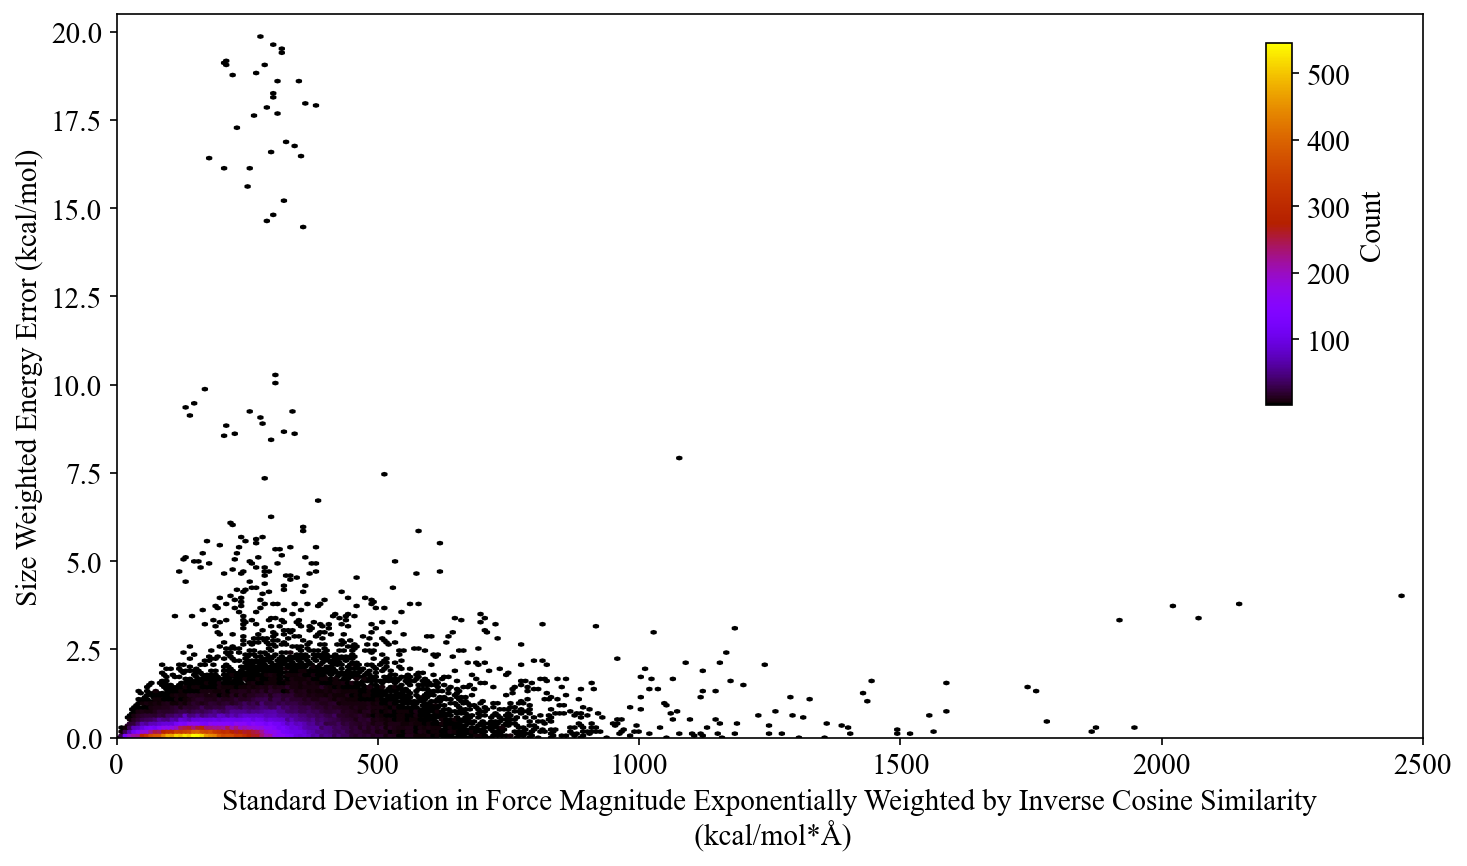

In [301]:
df["molecular_force_uncertainty_weighted_by_inv_cos_sim"] = df.apply(
    lambda row: compute_weighted_uncertainty(row["Stdev magnitudes"], 1 - np.array(row["Mean Cos Sim"]), alpha=1),
    axis=1
)

plt.figure(figsize=(10,6))
hb = plt.hexbin(df["molecular_force_uncertainty_weighted_by_inv_cos_sim"], df["size_weighted_energy_error"], 
                gridsize=300, cmap='gnuplot', mincnt=1)
# Add colorbar with bin count
cbar_ax = plt.gca().inset_axes([0.88, 0.46, 0.02, 0.5])  # [x-position, y-position, width, height]
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label("Count")  # Label the colorbar
plt.xlabel("Standard Deviation in Force Magnitude Exponentially Weighted by Inverse Cosine Similarity\n (kcal/mol*Å)", fontsize=14)
plt.ylabel("Size Weighted Energy Error (kcal/mol)", fontsize=14)
plt.xlim(0,2500)
plt.ylim(0,20.5)
plt.tight_layout()
plt.savefig('./figures/forces/cos_sim_exponential_weighting-vs-energy.png', dpi=300)
#plt.grid(True)
plt.show()

In [289]:
correlation_ = df["molecular_force_uncertainty_weighted_by_inv_cos_sim"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Safe Exp Force Uncertainty): {correlation_:.3f}")

Correlation (Safe Exp Force Uncertainty): 0.242


In [290]:
import numpy as np

def compute_exp_qbc_weighted_force_uncertainty(uncertainty_values, energy_qbc, alpha=1.0):
    """
    Compute an exponentially QBC-weighted mean of force uncertainty.

    uncertainty_values: (N_atoms,) array of per-atom uncertainties.
    energy_qbc: Single scalar value per molecule.
    alpha: Scaling factor for exponential weighting.

    Returns: Exponentially weighted molecular uncertainty (float)
    """
    uncertainty_values = np.array(uncertainty_values)

    # Ensure positive energy_qbc and avoid zero weights
    energy_weight = np.log1p(np.exp(alpha * np.abs(energy_qbc)))
    # Compute weighted mean
    weighted_mean = np.sum(uncertainty_values * energy_weight) / np.sum(energy_weight)
    return weighted_mean

# Apply exponential QBC weighting
alpha_value = 0.1  # Adjust for sensitivity
df["molecular_force_uncertainty_exp_weighted_by_qbc"] = df.apply(
    lambda row: compute_exp_qbc_weighted_force_uncertainty(row["atomistic_force_uncertainty_mean"], row["energy_qbc"], alpha=alpha_value),
    axis=1
)

# Compute correlation with energy error
correlation_exp_qbc_weighted = df["molecular_force_uncertainty_exp_weighted_by_qbc"].corr(df["size_weighted_energy_error"])
print(f"Correlation (Exp Weighted by energy_qbc, alpha={alpha_value}): {correlation_exp_qbc_weighted:.3f}")

Correlation (Exp Weighted by energy_qbc, alpha=0.1): 0.495


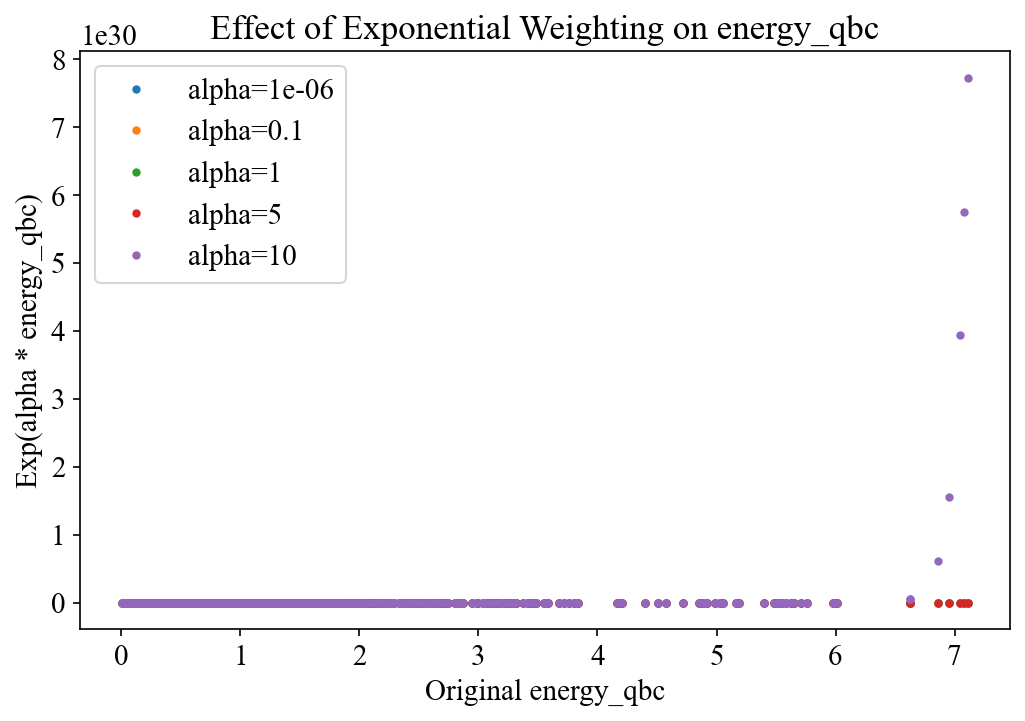

In [291]:
import matplotlib.pyplot as plt

# Extract energy_qbc values
qbc_values = df["energy_qbc"].values

# Choose alpha values to test
alpha_values = [1e-6, 0.1, 1, 5, 10]

plt.figure(figsize=(8, 5))

# Plot transformed values for different alphas
for alpha in alpha_values:
    transformed = np.exp(alpha * qbc_values)
    plt.plot(qbc_values, transformed, '.', label=f"alpha={alpha}")

plt.xlabel("Original energy_qbc")
plt.ylabel("Exp(alpha * energy_qbc)")
plt.legend()
plt.title("Effect of Exponential Weighting on energy_qbc")
plt.show()